# Introduction

abs

# Imports

In [81]:
%load_ext autoreload
%autoreload 2
# Data Wrangling & stats
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Helper Handles
from helperhandler import dataHolder
from helperhandler import get_ts_strength, adf_test, kpss_test

# Models & Stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.graphics.gofplots import qqplot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Path and Variable Initialisations

In [2]:
root_path = '../'
raw_datapath = root_path+'Raw Data/'
prepared_datapath = root_path+'Prepared Data/'

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,7)
plt.style.use('dark_background')
# plt.style.use('ggplot')

# Load and Explore the Data

In [304]:
dataHolder.load_data()
dataHolder.dataDf.tail()

,Handle,Short Description
10,anti_diabetic,AntiDiabetic Drug Sale
11,aus_elecprod,Electricity Production
12,visitor_20r,Visitors to 20 Regions
13,usa_economic,USA Economic Numbers
14,sunspots,Sunspot Numbers


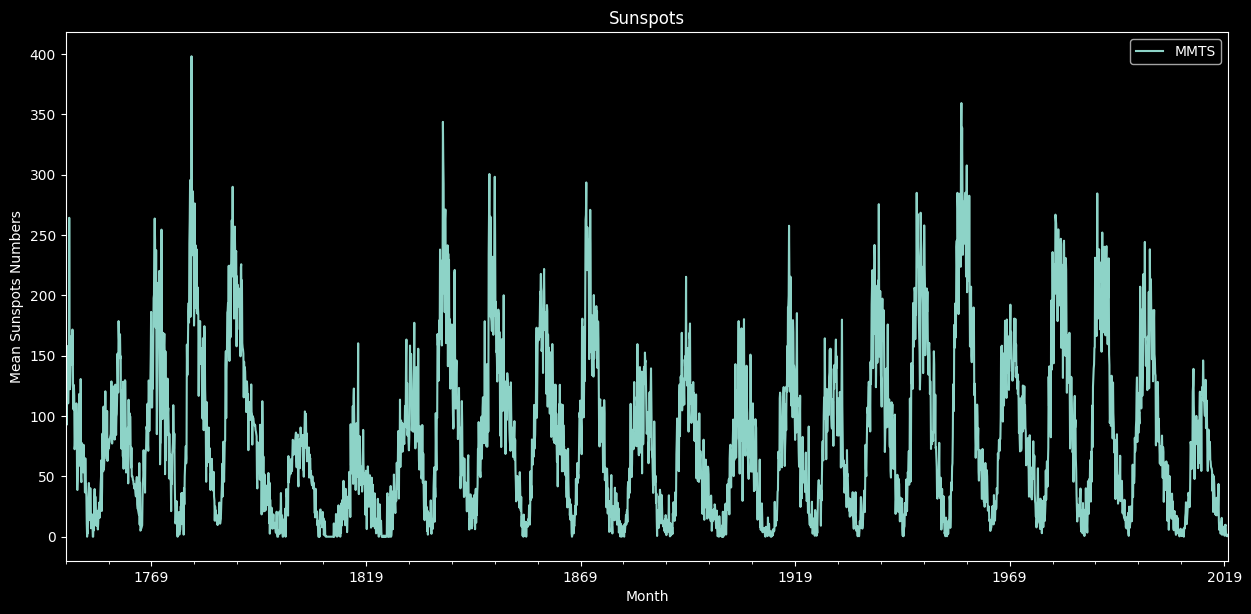

In [305]:
dataobj = dataHolder.bucket['sunspots']
sundata = dataobj.data.copy()
dataHolder.bucket['sunspots'].exploratory_plot()

In [306]:
sundata.index.freq = 'M'
sundata.head()

,MMTS
Month,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


# In-Depth Exploratory Data Analysis & Data Preperation

## Time Series Plot

Try slicing the data and see if you can find the following properties, and quantify them :
- Monthly Seasonality
- Cyclicity

Starting from 12, 24, 36... 11 years=122, 12 years = 144

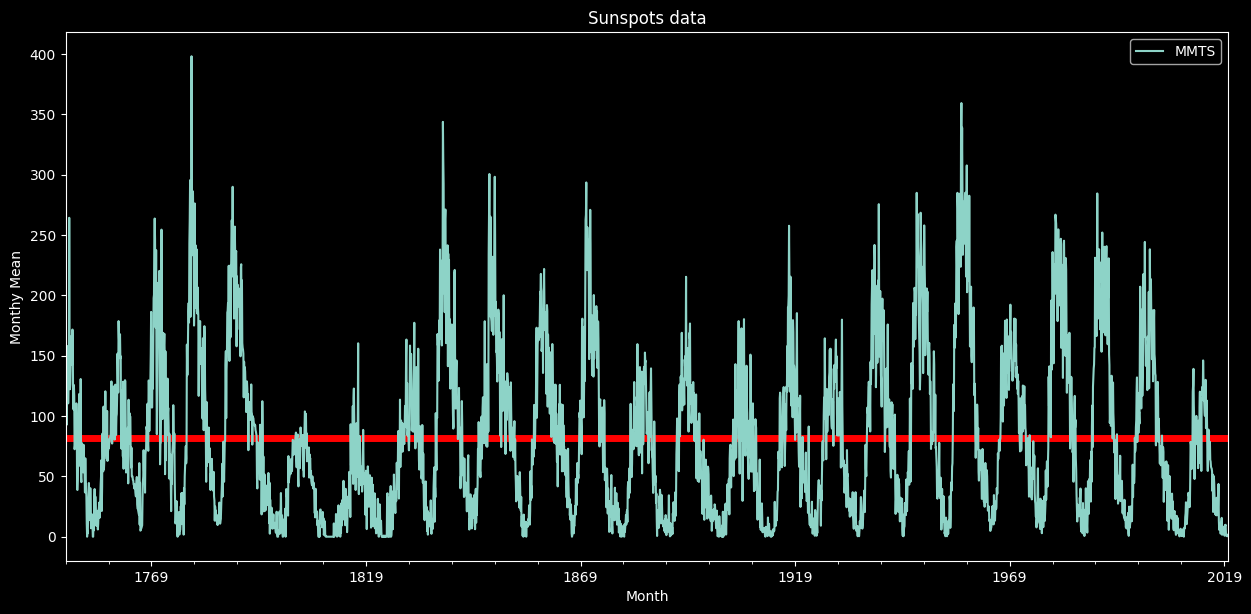

In [307]:
_=sundata.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(sundata.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

## Calendar Transformation on the data

In [308]:
pltdata = sundata.copy()

In [309]:
pltdata['MMTS_Adj'] = pltdata.MMTS/pltdata.index.daysinmonth
pltdata.head()

,MMTS,MMTS_Adj
Month,,
1749-01-31,96.7,3.119355
1749-02-28,104.3,3.725000
1749-03-31,116.7,3.764516
1749-04-30,92.8,3.093333
1749-05-31,141.7,4.570968


AttributeError: 'DataFrame' object has no attribute 'MMTS_Adj'

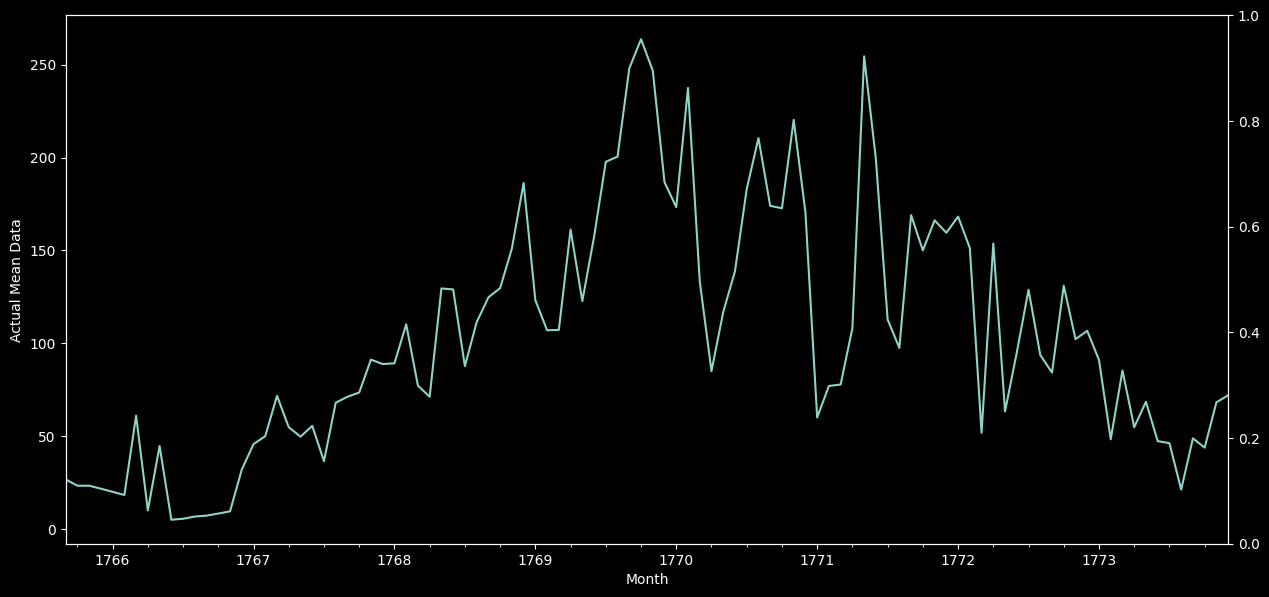

In [310]:
pltdata = sundata.copy()[200:300]
fig, axes=plt.subplots()
_=pltdata.MMTS.plot(ax=axes)
_=axes.set_ylabel('Actual Mean Data')
dx = axes.twinx()
_=pltdata.MMTS_Adj.plot(ax=dx, color='red', linestyle=':')
_=dx.set_ylabel('Monthday Adjusted Data')

<b>Is there any missing term?</b>

In [311]:
sundata.isna().sum()

MMTS    0
dtype: int64

## Seasonal/Variation Plot

In [312]:
pltdata = sundata.copy()

In [313]:
pltdata['Year'] = pltdata.index.year
pltdata['Month'] = pltdata.index.month
pltdata.head()

,MMTS,Year,Month
Month,,,
1749-01-31,96.7,1749,1
1749-02-28,104.3,1749,2
1749-03-31,116.7,1749,3
1749-04-30,92.8,1749,4
1749-05-31,141.7,1749,5


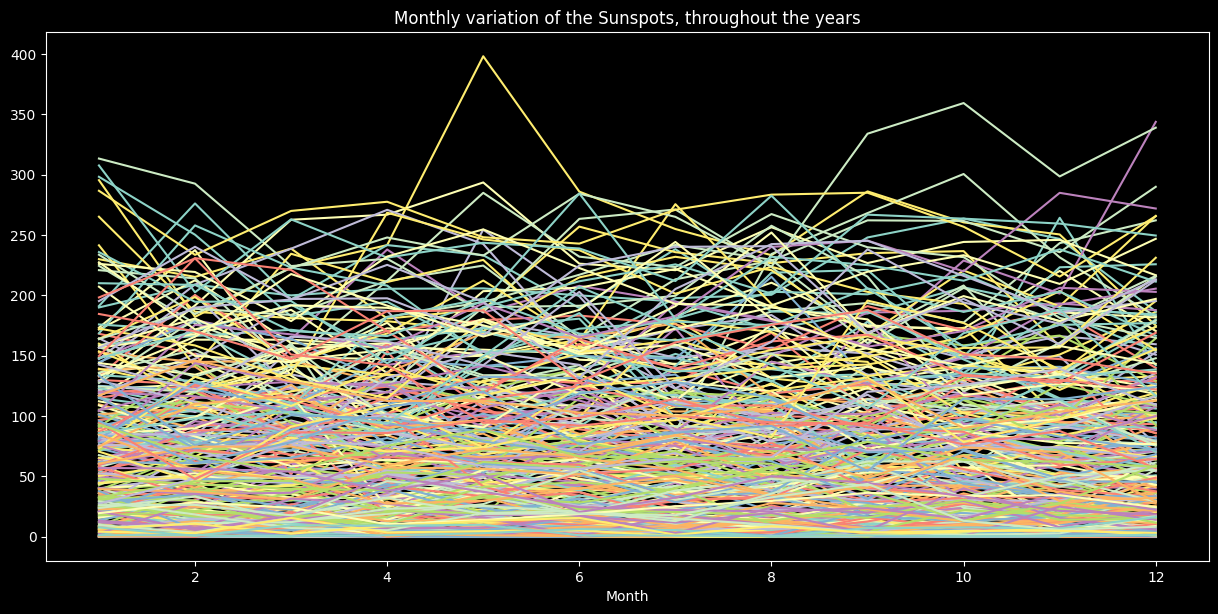

In [314]:
# For checking monthly seasonality
sundata_monthp = pltdata.pivot(index='Month', columns='Year', values='MMTS')
_=sundata_monthp.plot(legend=None,
                      title='Monthly variation of the Sunspots, throughout the years')

## Chop Plot

In [315]:
pltdata = sundata.copy()[7*12:]

,MMTS,Period
Month,,
1756-01-31,20.8,0
1756-02-29,11.8,0
1756-03-31,9.0,0
1756-04-30,15.7,0
1756-05-31,20.8,0


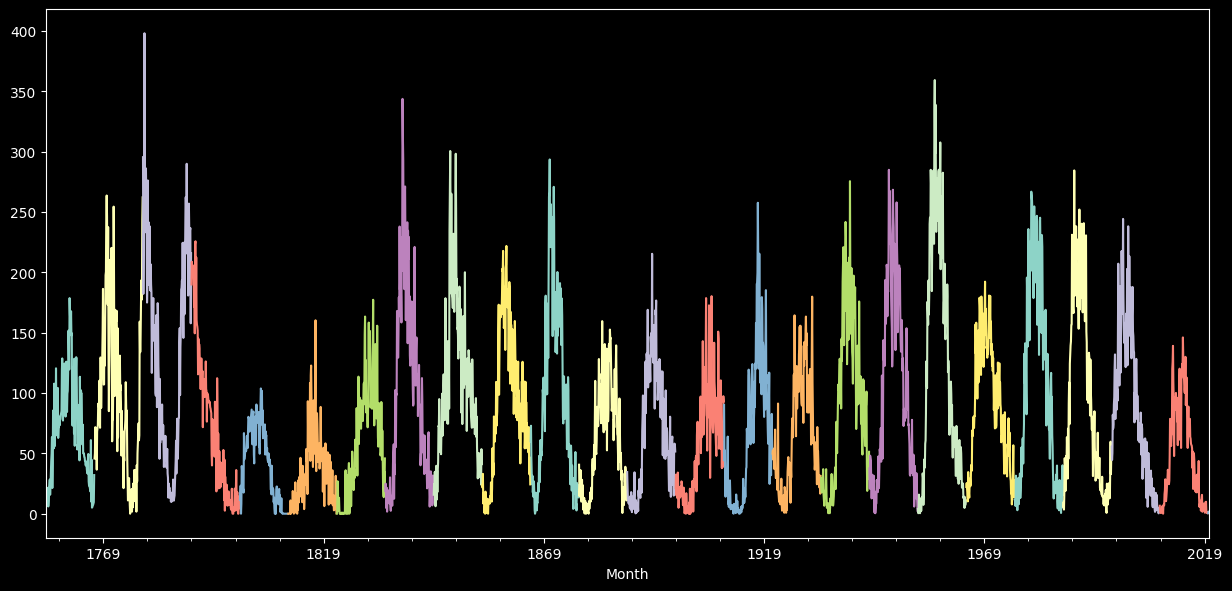

In [316]:
period = 11 # In years
start_date = pltdata.index.min()
def assign_periodlabel(x):
    tdiff = period*365
    _days = (x.name-start_date).days
    return _days//tdiff

pltdata['Period'] = pltdata.apply(lambda x : assign_periodlabel(x), axis=1)
_=pltdata.groupby('Period').MMTS.plot()
pltdata.head()

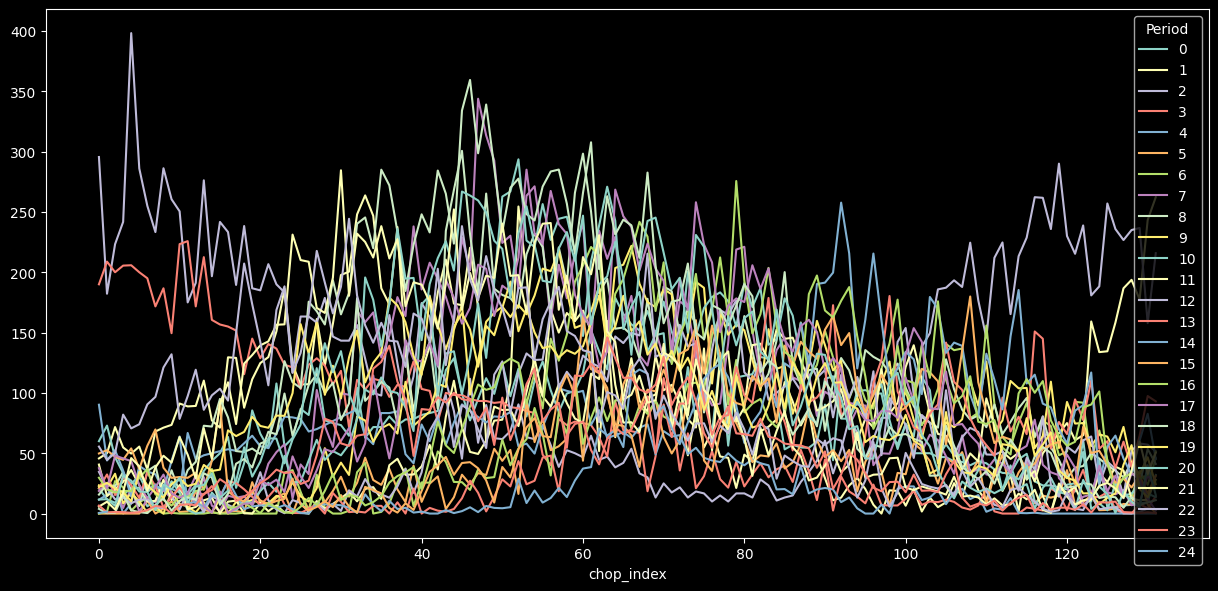

In [317]:
chop_indices = []
for each_period_counts in pltdata.groupby('Period').size().values:
    chop_indices += list(range(each_period_counts))
pltdata['chop_index'] = chop_indices
pltdata_chop = pltdata.pivot(index='chop_index',
                             columns='Period',
                             values='MMTS')
_=pltdata_chop.plot()

## Box  & Violin Plot

See as to which `period` makes the line more stable around the mean, to gauge into the Cyclicity behaviour of the model

In [318]:
pltdata = sundata.copy()

def get_boxp(period=10):
    """period is in years"""
    fig,axes = plt.subplots()
    start_date = pltdata.index.min()
    def assign_periodlabel(x):
        tdiff = period*365
        _days = (x.name-start_date).days
        return _days//tdiff
    pltdata['Period'] = pltdata.apply(lambda x : assign_periodlabel(x), axis=1)
    _=sns.boxplot(x='Period',y='MMTS',data=pltdata, ax=axes)
    _=pltdata.groupby('Period').mean().plot(ax=axes, color='red', linewidth=5)
    _=plt.title('Box Plot')

    
def get_violinp(period=10):
    """period is in years"""
    fig,axes = plt.subplots()
    start_date = pltdata.index.min()
    def assign_periodlabel(x):
        tdiff = period*365
        _days = (x.name-start_date).days
        return _days//tdiff
    pltdata['Period'] = pltdata.apply(lambda x : assign_periodlabel(x), axis=1)
    _=sns.violinplot(x='Period',y='MMTS',data=pltdata, ax=axes)
    _=pltdata.groupby('Period').mean().plot(ax=axes, color='red', linewidth=5)
    _=plt.title('Box Plot')



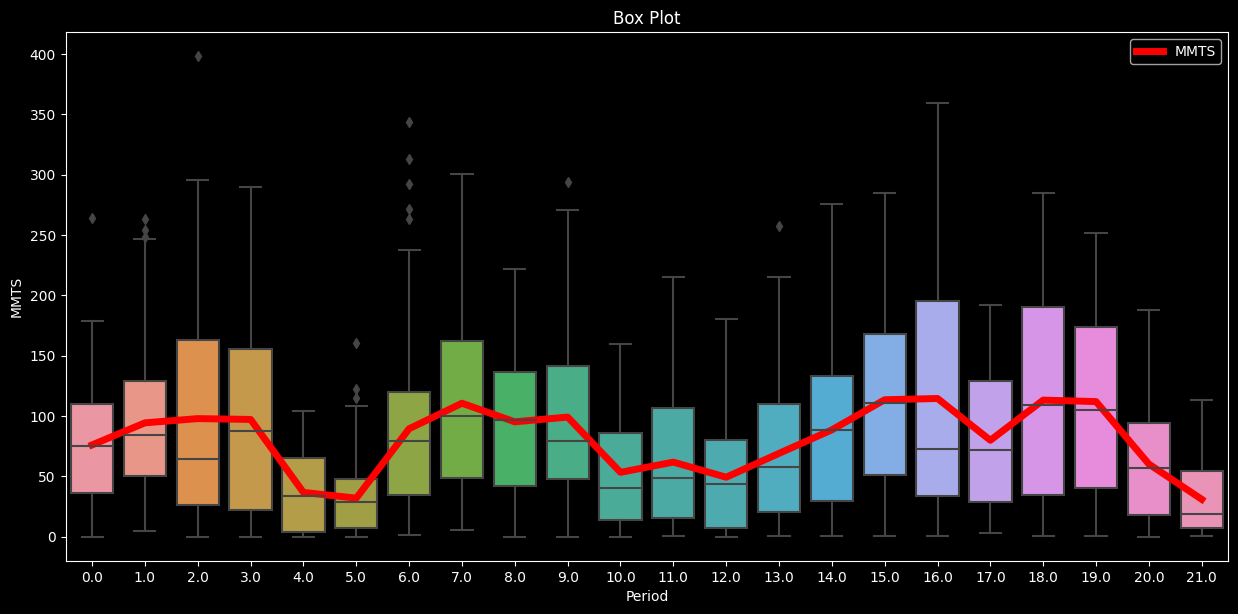

In [319]:
get_boxp(12+(8/12))

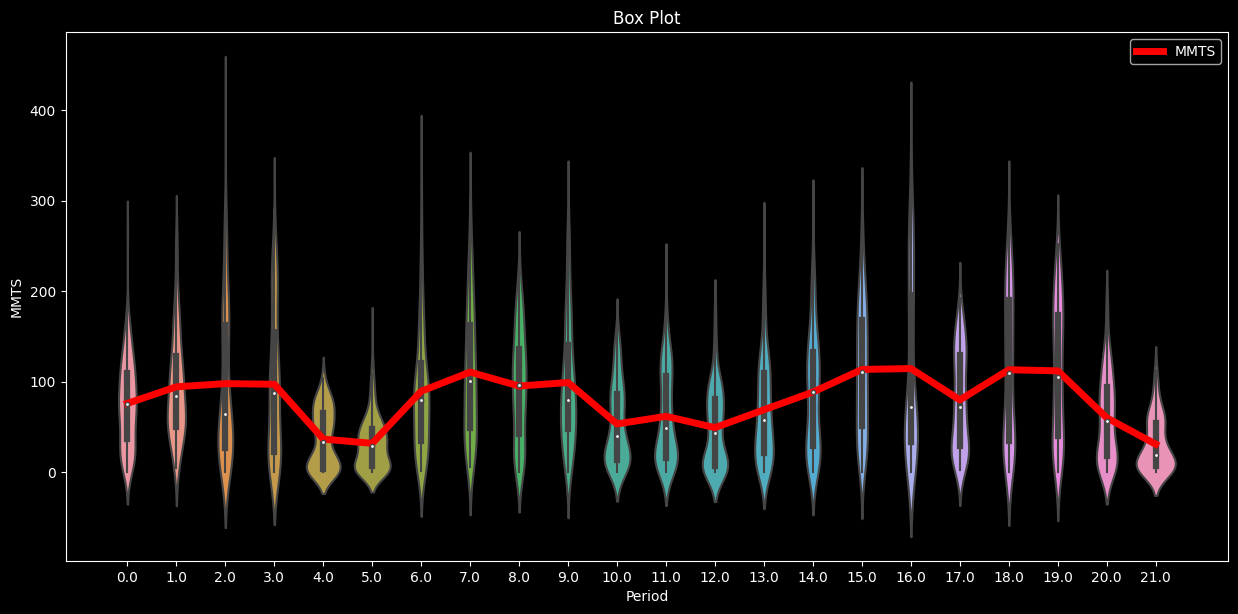

In [320]:
get_violinp(12+(8/12))

## Decomposition

The period parameter will be filled by the cyclic componet as observed in the 5.5 section, and then try for 12 to decompose for the yearly frequency.

Look at the extrapolate trend parameter

,Trend,Seasonal
Strength,0.176877,0.288146


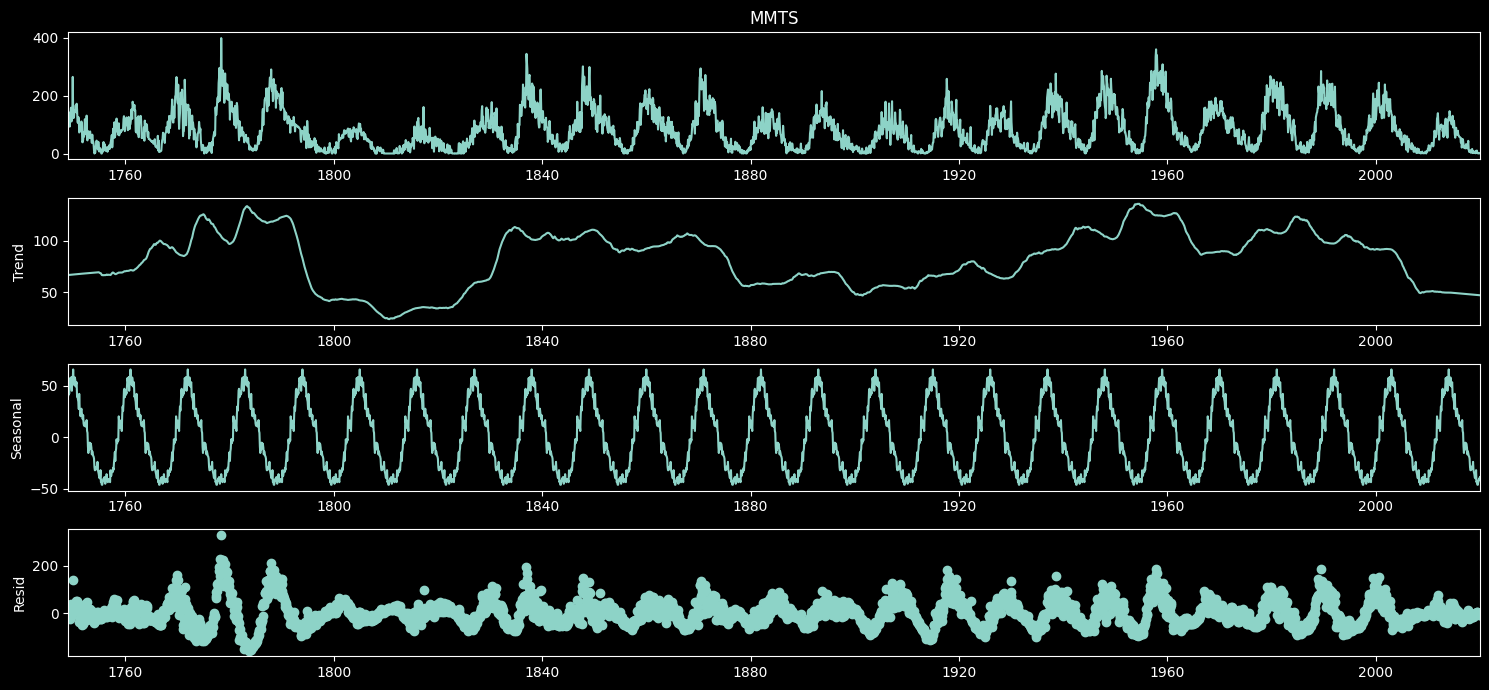

In [321]:
adecomp_obj = seasonal_decompose(sundata.MMTS, model='additive', period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

In [322]:
adecomp_obj = seasonal_decompose(sundata.MMTS, model='multiplicative', period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

<b>Since none of the above decompositions gave a promising measure of seasonality</b>
    
Lets try the STL decomposition model

,Trend,Seasonal
Strength,0.887779,0.011484


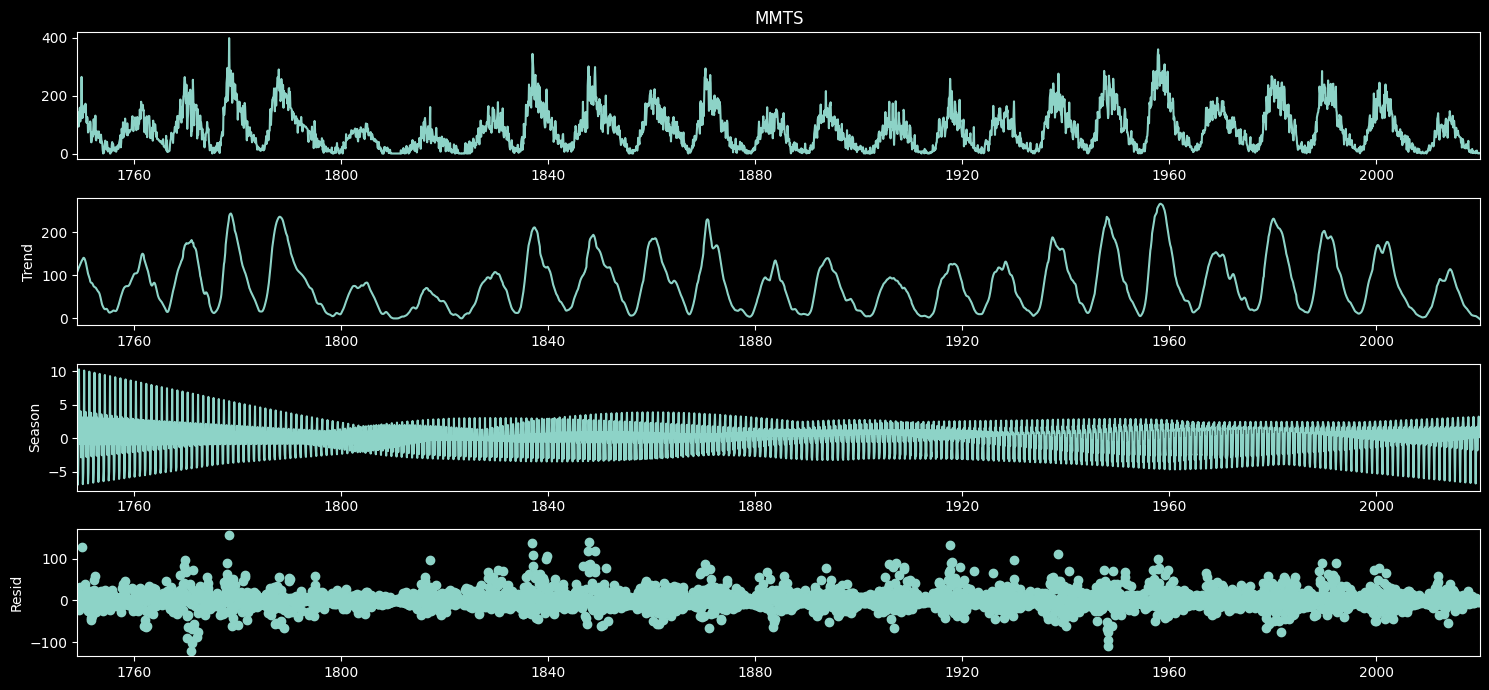

In [323]:
stl = STL(sundata.MMTS, seasonal=10*12-1, robust=True)
res = stl.fit()
fig = res.plot()
get_ts_strength(res).T

# Gauging its Statistics

- Stationarity Test
- Looking in the ACF and PACF
- Distribution Test

<b>Stationarity Test</b>

In [324]:
adf_test(sundata.MMTS)

,0
Test Statistic,-1.048087e+01
p-value,1.214714e-18
#Lags Used,2.800000e+01
Number of Observations Used,3.223000e+03
Critical Value (1%),-3.432381e+00
Critical Value (5%),-2.862437e+00
Critical Value (10%),-2.567248e+00


In [325]:
kpss_test(sundata.MMTS)

,0
Test Statistic,0.112303
p-value,0.100000
Lags Used,36.000000
Critical Value (10%),0.347000
Critical Value (5%),0.463000
Critical Value (2.5%),0.574000
Critical Value (1%),0.739000


Through the results it seems to be stationary

**A time series with cyclic behavior (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time.**

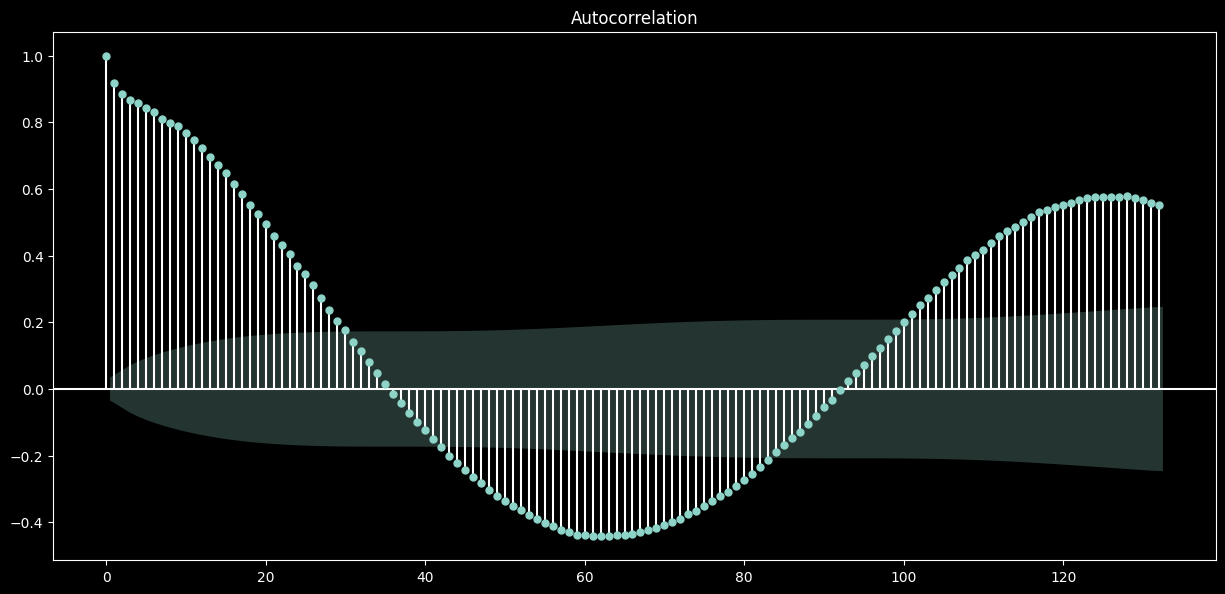

In [326]:
_=plot_acf(sundata.MMTS, lags=11*12)

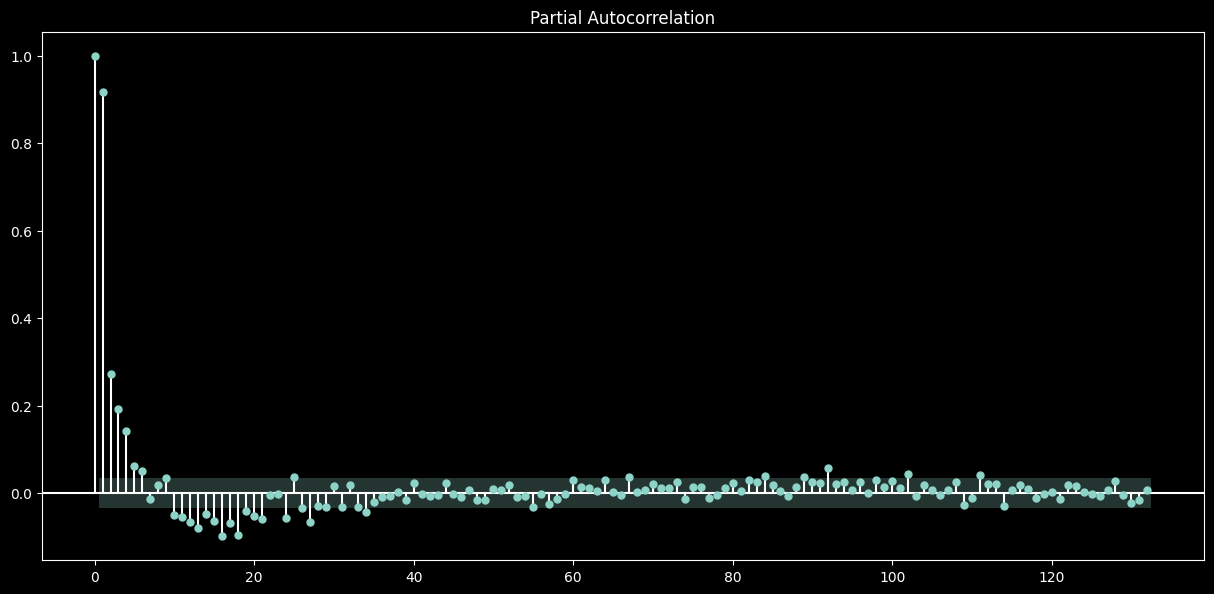

In [327]:
_=plot_pacf(sundata.MMTS, lags=11*12)

# Preparing Modelling Function

As discussed in the previos notebook, the best methodology to predict a time series is via the `Rolling-Origin` forecast, 

i.e ***Utilise the fact that time series data generation is a `frequency` based process and we will get the data accordingly, so it will be best to use that data to make the forecasts***

In [244]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arma_mle import Arma

In [345]:
import copy

def ro_framework(data, model, model_params, 
                 target_col, feature_cols,
                 test_start, cv_window, ahead_offest,
                 metric='MAPE', debug=True, ahead_offest_freq='days'):
    # Three libraries - statsmodels, sklearn, prophet
    
    # Checks
    _tfreq = ['years', 'months', 'weeks', 'days', 'hours', 'minutes',
              'seconds', 'microseconds', 'nanoseconds']
    if not (hasattr(model, 'fit') & hasattr(model, 'predict')):
        raise ValueError("Model Passed should be having '.fit' & '.predict' methods, i.e foloowing the sklearn API")
    if data.shape[0]<10:
        raise ValueError("Data used for modelling should be greater than 10 datapoints")
    if type(data) != pd.core.frame.DataFrame:
        raise ValueError("Data should be a pandas dataframe of type 'pd.DataFrame'")
    if type(data.index) != pd.core.indexes.datetimes.DatetimeIndex:
        raise ValueError("Data should be having index of type 'pd.DatetimeIndex'")
    if not (type(test_start) == str or type(test_start) == pd._libs.tslibs.timestamps.Timestamp):
        raise ValueError("'test_start' should be a 'pd.Timestamp' or 'str'")
    if not (pd.to_datetime(test_start)>data.index[0] and pd.to_datetime(test_start)<data.index[-1]):
        raise ValueError("'test_start' should be in between {0} and {1}".format(data.index.min(),
                                                                                data.index.max()))
    if not type(ahead_offest) == pd._libs.tslibs.offsets.DateOffset:
        raise ValueError("'ahead_offest' should be a 'pd.DateOffset'")
    if type(cv_window) != int:
        raise ValueError("'cv_window' should be an `int`")
    if not any([ahead_offest_freq==k for k in _tfreq]):
        raise ValueError(f"'ahead_offest_freq' should be one of {_tfreq}")
    if getattr(ahead_offest, ahead_offest_freq) <= 0:
        raise ValueError(f"'ahead_offest' should be greater than `0 {ahead_offest_freq}`")
    if target_col not in data.columns:
        raise ValueError(f"{target_col} not found in `data`")
    if feature_cols:
        missing_feats = [k for k in feature_cols if k not in data.columns]
        if missing_feats:
            raise ValueError(f"{missing_feats} columns not present in the dataset")
    if data.index.freq == None:
        raise ValueError(f"data.index.freq should not be `None`")

    # Initialisations
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    model = copy.deepcopy(model)
    
    modelling_data = data.copy()
    modelling_data.sort_index(inplace=True)
    
    training_data = data[data.index<test_start].copy()
    testing_data = data[data.index>=test_start].copy()

    train_start = training_data.index[0]
    
    test_start = pd.to_datetime(test_start)
    test_end = modelling_data.index[-1]
    
    if cv_window > training_data.shape[0]*0.5:
        raise ValueError("`cv_window` should be less than {}".format(int(training_data.shape[0]*0.5)))
    
    
    
    # Fore debugging purpose
    if debug:
        debugDF = pd.DataFrame(columns=['Train Start', 'Train End', 'CV Point', 'Diff'])
        for cv_date in training_data.index[-cv_window:]:
            train_end = cv_date-ahead_offest
            _packet = {'Train Start': train_start, 'Train End': train_end,
                       'CV Point': cv_date, 'Diff': str(getattr(ahead_offest, ahead_offest_freq))+' '+ahead_offest_freq}
            debugDF = debugDF.append(_packet, ignore_index=True)
        display(debugDF)
    
    
    # Picking the Metrics
    if metric == 'MAPE':
        metric_func = lambda y,yhat: np.round(100*(abs(np.array(y)-np.array(yhat))/np.array(y)),2)
    elif metric == 'MSE':
        metric_func = lambda y,yhat: np.round(100*(abs(np.array(y)-np.array(yhat))/np.array(y)),2)
    
    
    # Cross Validation Loop
    for cv_date in training_data.index[-cv_window:]:
        train_end = cv_date-ahead_offest
        
        # Filter the data
        _train_data = training_data.truncate(before=train_start, after=train_end)
        _cv_data = training_data.loc[cv_date].to_frame().T
        
        if feature_cols:
            # Multivariate
            pass
        else:
            # Univariate
            if 'statsmodels' in str(model):
                # Update Model Params Based on library
                model_params['endog'] = _train_data[target_col]
                modeldef = model(**model_params)
                
                fitted_model = modeldef.fit()
                _forecast = fitted_model.predict(start=cv_date, end=cv_date).values[0]
                _actual = _cv_data[target_col].values[0]

        # Update Metric Sheets
        cvDF.loc[cv_date, 'Actual'] = _actual
        cvDF.loc[cv_date, 'Forecast'] = _forecast
        cvDF.loc[cv_date,  metric] = metric_func(_actual, _forecast)
    
    
    # Testing - Using the last fitted_model
    if 'statsmodels' in str(model):
        testDF['Actual'] = testing_data[target_col]
        testDF['Forecast'] = fitted_model.predict(start=test_start, end=test_end)
        testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    # Prepare Overall Metric
    overallDF = pd.DataFrame([cvDF[metric].mean(), testDF[metric].mean()],
                             columns=['Overall '+metric],
                             index=['CV', 'Test'])
    
    return cvDF, testDF, overallDF, fitted_model


# AR Model

In [ ]:
respacket=ro_framework(data = sundata, model = AutoReg, model_params = {'lags':124},
                       test_start = '1966-01-31', cv_window = 15,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=1),
                       metric='MAPE', debug=True, ahead_offest_freq='months')

cvDF, testDF, overallDF, fitted_model = respacket

## Drawing parallels with the Regression

# MA Model

# ARMA Model

# ARIMA Model

# SARIMA Model

# Prophet Model

# GAM Model

# Random Testing Space

In [ ]:
# from helperhandler import dataHolder
# dataHolder.load_data()
# dataobj = dataHolder.bucket['sunspots']
# sundata = dataobj.data.copy()

In [ ]:
# %load_ext autoreload
# %autoreload 2
# import tsmad as tmd
# from tsmad import TSMAD_CONFIGS

In [ ]:
# tboard = tmd.TsmadBoard(tsdata=sundata[-500:].copy(),
#                        data_desc=dataobj.long_description, 
#                        target_columns=['MMTS'], dt_freq='M',
#                        freq_conv_agg = 'mean')
# TSMAD_CONFIGS['plotting.default_engine'] = 'Interactive'
# tboard.get_board()

In [186]:
{k:None for k in ['Train Start', 'Train End', 'CV Point', 'Diff']}

{'Train Start': None, 'Train End': None, 'CV Point': None, 'Diff': None}

inf